In [1]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = "/root/autodl-tmp/model/gemma3n_E2B", # gemma3n-e2b:5B gemma3n-e4b:8B
    max_seq_length = 4096, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    attn_implementation = "eager", # necessary
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.2: Fast Gemma3N patching. Transformers: 4.53.2.
   \\   /|    NVIDIA RTX 5880 Ada Generation. Num GPUs = 1. Max memory: 47.383 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,                  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 408,             
    target_modules = "all-linear",    
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


### Data Prep
You can access the dataset from [huggingface](https://huggingface.co/datasets/Argobell/gek408) or [modelscope](https://modelscope.cn/datasets/Argobell/gek408).

In [1]:
from datasets import load_dataset

dataset = load_dataset("../dataset", split = "train")
print(dataset)

Dataset({
    features: ['question', 'solution', 'image', 'difficult'],
    num_rows: 5186
})


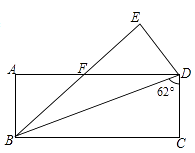

In [5]:
dataset[10]["image"]

In [6]:
dataset[10]["solution"]

'### Solution  \n1. Rectangle \\(ABCD\\) implies \\(AD \\parallel BC\\) and \\(\\angle ADC = 90^\\circ\\).  \n2. Given \\(\\angle BDC = 62^\\circ\\), compute \\(\\angle FDB = 90^\\circ - 62^\\circ = 28^\\circ\\).  \n3. Since \\(AD \\parallel BC\\), alternate-interior angles give \\(\\angle CBD = \\angle FDB = 28^\\circ\\).  \n4. Folding along \\(BD\\) preserves angles, so \\(\\angle FBD = \\angle CBD = 28^\\circ\\).  \n5. The exterior angle \\(\\angle DFE\\) is the sum of \\(\\angle FBD\\) and \\(\\angle FDB\\), yielding \\(28^\\circ + 28^\\circ = 56^\\circ\\).  \n\n### Final Answer  \n\\(\\boxed{56^\\circ}\\)'

To format the dataset, all vision fine-tuning tasks should follow this format:

```python
[
    {
        "role": "user",
        "content": [
            {"type": "text", "text": sample["question"]},
            {"type": "image", "image": sample["image"]},
        ],
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": sample["question"]},
            {"type": "image", "image": sample["image"]},
        ],
    },
]
```

In [1]:
def convert2conversation(sample):
    instruction = sample["question"]
    
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["solution"]}]},
    ]
    return {"messages": conversation}

In [8]:
converted_dataset = [convert2conversation(sample) for sample in dataset]

In [9]:
converted_dataset[10]["messages"][0]

{'role': 'user',
 'content': [{'type': 'text',
   'text': 'As shown in the diagram, rectangle $ABCD$ is folded along the diagonal $BD$, with point $C$ falling on point $E$. $BE$ intersects $AD$ at point $F$. Given that $\\angle BDC=62^\\circ$, what is the measure of $\\angle DFE$?'},
  {'type': 'image',
   'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=195x153>}]}

In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    processing_class=tokenizer.tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    args = SFTConfig(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 4,
        gradient_checkpointing = True,

        # use reentrant checkpointing
        gradient_checkpointing_kwargs = {"use_reentrant": False},
        max_grad_norm = 0.3,              # max gradient norm based on QLoRA paper
        warmup_ratio = 0.03,
        # max_steps = 30,
        num_train_epochs = 2,          # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        save_strategy="steps",
        optim = "adamw_torch_fused",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 408,
        output_dir = "outputs",
        report_to = "none",             # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_seq_length = 2048,
    )
)

Unsloth: Model does not have a default image size - using 512


In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 5,186 | Num Epochs = 2 | Total steps = 326
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 42,270,720 of 5,481,708,992 (0.77% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,7.958700
2,7.825400
3,3.763200
4,2.676500
5,2.395900
6,2.142800
7,1.909900
8,1.899400
9,1.645300
10,1.508700


In [12]:
torch.cuda.empty_cache()

In [13]:
model.save_pretrained("../checkpoints/gemma-3n")
tokenizer.save_pretrained("../checkpoints/gemma-3n")

['../checkpoints/gemma-3n/processor_config.json']

In [14]:
model.save_pretrained_merged("../checkpoints/gemma-3n-finetune", tokenizer)

Detected local model directory: /root/autodl-tmp/model/gemma3n_E2B
No existing and accessible Hugging Face cache directory found.
Copying safetensors from local directory: /root/autodl-tmp/model/gemma3n_E2B
Copied safetensors index file from local model


Unsloth: Merging weights into 16bit:   0%|          | 0/3 [00:00<?, ?it/s]

Copied model-00003-of-00003.safetensors from local model directory


Unsloth: Merging weights into 16bit:  33%|███▎      | 1/3 [00:08<00:16,  8.33s/it]

Copied model-00001-of-00003.safetensors from local model directory


Unsloth: Merging weights into 16bit:  67%|██████▋   | 2/3 [00:15<00:07,  7.50s/it]

Copied model-00002-of-00003.safetensors from local model directory


Unsloth: Merging weights into 16bit: 100%|██████████| 3/3 [00:26<00:00,  8.84s/it]
